<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/01_AR_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AR(p) 모델

- 만약 **AR(1) 모델**을 사용하려면 `lags=1`로 설정  
  ```python
  model = AutoReg(train["Close"], lags=1)


# 시계열 예측방법
* 전체(Full series)
* 고정 원점(=정적 파라미터) 예측
* 롤링 윈도우(Rolling window)
* 확장 윈도우(Expanding window)




# 추가 팁

* **레벨(가격)**보다 **차분/수익률**에 AR(p)을 쓰면 안정적인 경우가 많습니다.
* 멀티스텝 예측은

  * **재귀(recursive)**: 1스텝 모델로 여러 스텝을 순차 예측(지금 코드)
  * **직접(direct)**: 각 horizon마다 별도 모델 학습
  * **DirRec/MLP 등 혼합** 방식도 있습니다.



# 전체(Full series)

한 번에 **전체 구간**(1–10)으로 학습하고, 다음 시점(11)을 예측.
(평가용으론 데이터 누수 위험, 주로 최종 모델 적합에 사용)

```
1—2—3—4—5—6—7—8—9—10  →  (학습)  →  예측 11
```

좋아! 아래는 **Full series(전체 구간으로 한 번 학습 → 미래 예측)**의 **의사코드**야.

# Full series 의사코드 (AR(p), 재귀 예측)

```text
입력:
  y[1..T]        # 관측 시계열
  p              # AR 차수
  h              # 예측 horizon (미래 h스텝)

절차:
1) 모델 적합
   θ ← AR(p)을 y[1..T] 전체로 적합 (재학습 없음)

2) 재귀 예측 (one-step을 h번 이어서)
   for k = 1..h:
       # t = T+k 시점 예측식
       # 실제값 y[..T]와, 이미 예측한 ŷ[T+1..T+k-1]을 섞어서 사용
       ŷ[T+k] ← φ0
                 + Σ_{i=1..p} φ_i * Z[T+k-i]
       여기서 Z[t] = {
         y[t]      if t ≤ T     (과거 관측치)
         ŷ[t]     if t >  T     (직전 스텝 예측치)
       }

3) 출력
   반환: (ŷ[T+1], ŷ[T+2], ..., ŷ[T+h])
```

* 특징: **전체 표본**로 **한 번만** 학습하고(정적 파라미터), 그 상태로 미래를 **재귀적으로** 예측.
* 주의: 평가용으로 쓰면 **데이터 누수** 위험 → 보통은 최종 배치 적합 또는 운영 예측에 사용.


# 모델-일반형 의사코드 (AR 외 어떤 모델에도)

```text
입력: 데이터 D(=전체 시계열 y[1..T] 및 필요한 특징), horizon h
1) θ ← fit(model, D)           # 전체로 한 번 학습
2) ŷ[1..h] ← forecast(θ, h)    # 모델의 예측 API로 h 스텝 생성
3) 반환: ŷ
```

> 대부분의 라이브러리는 위 “일반형” 호출로 구현되며, AR(p)은 내부적으로 위의 **재귀 로직**을 수행한다고 보면 돼.


/tmp/ipython-input-1167288979.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("TSLA", start="2022-01-01", end="2025-09-30").reset_index()
[*********************100%***********************]  1 of 1 completed


                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  938
Model:                    AutoReg(10)   Log Likelihood               -3455.234
Method:               Conditional MLE   S.D. of innovations             10.018
Date:                Mon, 06 Oct 2025   AIC                           6934.468
Time:                        12:11:38   BIC                           6992.464
Sample:                            10   HQIC                          6956.590
                                  938                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8298      1.298      2.180      0.029       0.286       5.374
y.L1           0.9965      0.033     30.567      0.000       0.933       1.060
y.L2           0.0169      0.046      0.367      0.7

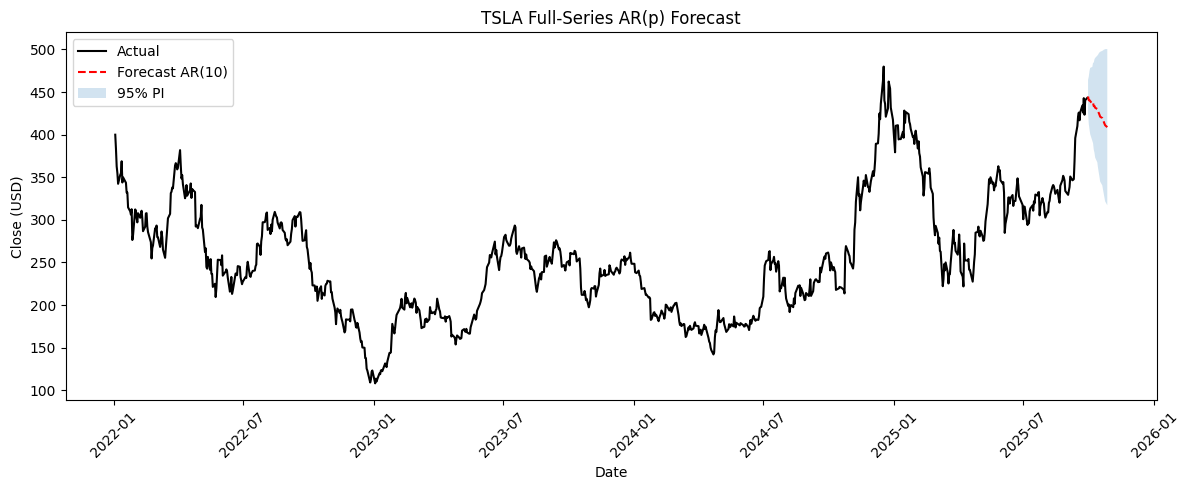

In [6]:
# Full-series AR(p) forecast (no refit, no holdout)
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

# 1) 데이터 로드 (TSLA, 최근 3년)
df = yf.download("TSLA", start="2022-01-01", end="2025-09-30").reset_index()
y = df["Close"].to_numpy()
dates = df["Date"].to_numpy()

# 2) AR(p) 전체 구간 학습
p = 10  # 차수
fit = AutoReg(y, lags=p, old_names=False).fit()
print(fit.summary())

# 3) 미래 h 스텝 예측
h = 20  # 예: 앞으로 20 거래일
fc = np.asarray(fit.forecast(steps=h))          # 예측값 벡터
last_day = pd.to_datetime(dates[-1])
fc_dates = pd.bdate_range(last_day + pd.Timedelta(days=1), periods=h)  # 예측 날짜(영업일 기준)

# (선택) 예측구간(confidence interval) — statsmodels 버전에 따라 지원
try:
    pred_res = fit.get_prediction(start=len(y), end=len(y) + h - 1)
    ci = pred_res.conf_int(alpha=0.05)  # 95% PI
    ci_lower = ci[:, 0]
    ci_upper = ci[:, 1]
except Exception:
    ci_lower = ci_upper = None

# 4) 시각화
plt.figure(figsize=(12,5))
plt.plot(dates, y, label="Actual", color="black")
plt.plot(fc_dates, fc, label=f"Forecast AR({p})", linestyle="--", color="red")
if ci_lower is not None:
    plt.fill_between(fc_dates, ci_lower, ci_upper, alpha=0.2, label="95% PI")
plt.title("TSLA Full-Series AR(p) Forecast")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout()
plt.show()


# 고정 원점(=정적 파라미터) 예측  

첫 80%로 **한 번만 학습** → 그 파라미터로 **남은 전 구간을 재귀 예측**.
고정 학습구간으로 한 번만 학습하고(첫 80%), 그 파라미터를 테스트 전 구간에 그대로 쓰는** 방식은
* **고정 원점 예측 (Fixed-origin forecast)**
* **단일 홀드아웃(split) 평가 / 정적 파라미터 모델 (static-parameter, no-refit)**
* (예측을 한 번에 여러 스텝 내다보는 형태이므로) **고정 원점 다단계 *재귀* 예측 (fixed-origin recursive multi-step)**

> 요점: **재학습(refit) 없음**, 원점(origin)을 **train 끝 시점**에 고정해 그 이후를 쭉 예측.

```
[1—2—3—4—5—6—7—8] → 예측 9,10 …
(재학습 없음)
```

**의사코드 (AR(p))**

```python
fit = AutoReg(y[:train_end], lags=p).fit()
yhat[train_end:] = fit.predict(start=train_end, end=n-1)  # 고정 원점, 재학습 없음
```

* 장점: 빠르고 간단, 재현성 높음
* 단점: **드리프트에 둔감**, 멀리 갈수록 오차 누적(재귀 다단계)


/tmp/ipython-input-2433316129.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("TSLA", start="2022-01-01", end="2025-09-30")
[*********************100%***********************]  1 of 1 completed


📌 Training MSE: 82.3140, R²: 0.9762
📌 Test MSE: 5125.8919, R²: -0.7349


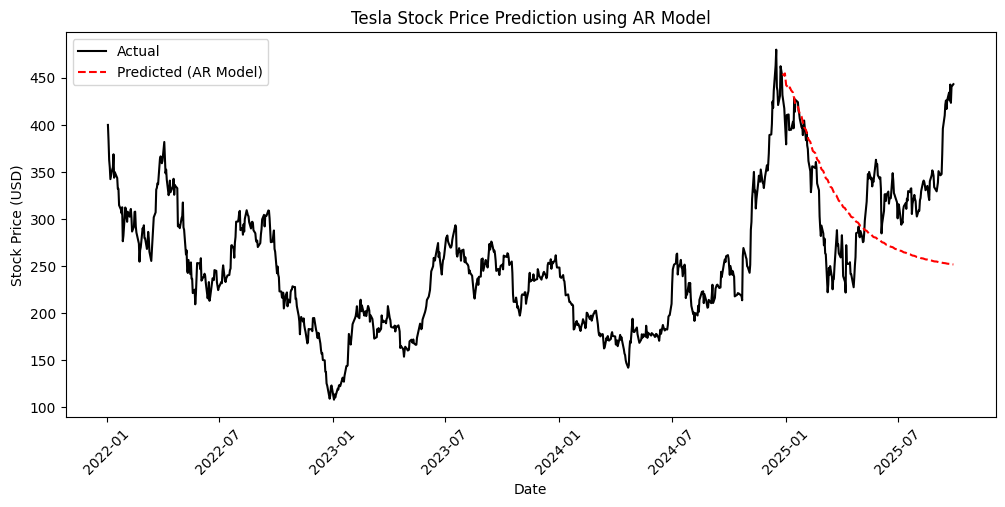

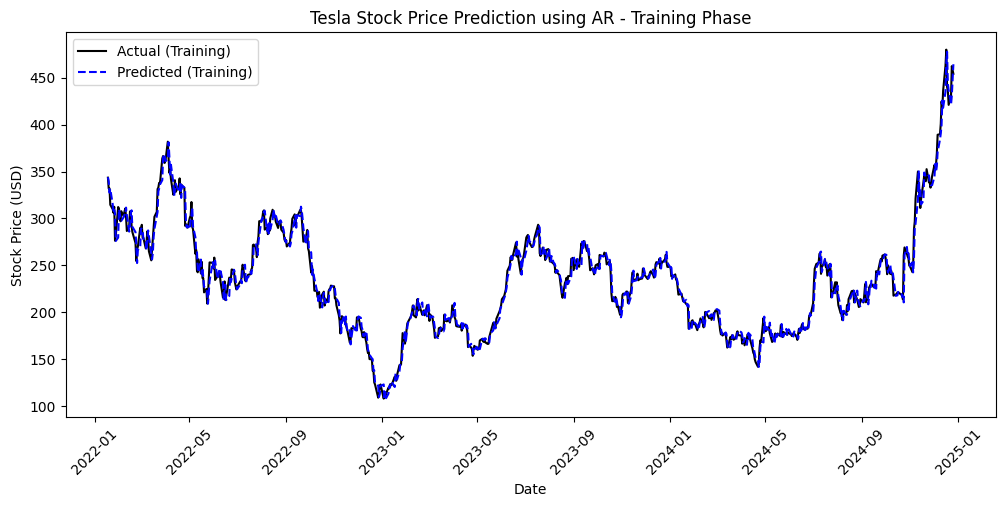

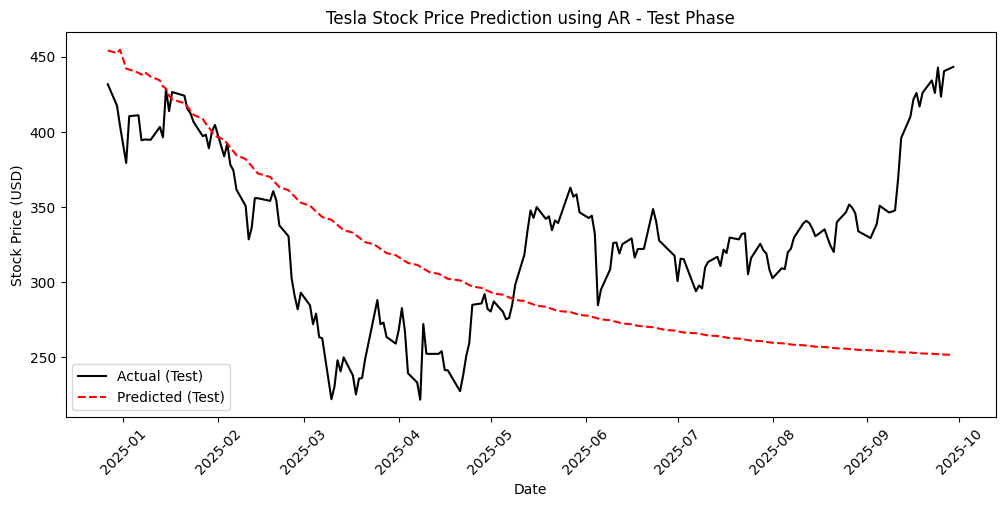

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, r2_score

# 📌 1️⃣ 테슬라(TSLA) 주가 데이터 다운로드 (최근 3년치)
df = yf.download("TSLA", start="2022-01-01", end="2025-09-30")

# 데이터프레임 변환
df = df.reset_index()

# 📌 2️⃣ Feature 생성: 날짜를 숫자로 변환
df["Day"] = np.arange(len(df))

# 📌 3️⃣ 입력 변수(X) 및 출력 변수(y) 정의
X = df[["Day"]].values  # 날짜를 입력 변수로 사용
y = df["Close"].values  # 종가(Close)를 예측할 목표 변수로 사용

# 📌 4️⃣ 학습 및 테스트 데이터 분할 (80% 학습, 20% 테스트)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# 📌 5️⃣ AR(자동회귀) 모델 학습
lag = 10  # AR 모델의 시차 설정
model = AutoReg(train["Close"], lags=lag)
model_fit = model.fit()

# 📌 6️⃣ 예측 수행
train_pred = model_fit.predict(start=lag, end=len(train) - 1)  # 훈련 데이터 예측
test_pred = model_fit.predict(start=len(train), end=len(df) - 1)  # 테스트 데이터 예측

# 📌 7️⃣ 성능 평가
train_mse = mean_squared_error(train["Close"][lag:], train_pred)
test_mse = mean_squared_error(test["Close"], test_pred)
train_r2 = r2_score(train["Close"][lag:], train_pred)
test_r2 = r2_score(test["Close"], test_pred)

print(f"📌 Training MSE: {train_mse:.4f}, R²: {train_r2:.4f}")
print(f"📌 Test MSE: {test_mse:.4f}, R²: {test_r2:.4f}")

# 📌 8️⃣ 결과 시각화 (전체 데이터 예측)
plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["Close"], label="Actual", color="black")
plt.plot(test["Date"], test_pred, label="Predicted (AR Model)", linestyle="--", color="red")
plt.title("Tesla Stock Price Prediction using AR Model")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# 📌 9️⃣ 결과 시각화 (훈련 데이터 예측 vs 실제값)
plt.figure(figsize=(12, 5))
plt.plot(train["Date"][lag:], train["Close"][lag:], label="Actual (Training)", color="black")
plt.plot(train["Date"][lag:], train_pred, label="Predicted (Training)", color="blue", linestyle="--")
plt.title("Tesla Stock Price Prediction using AR - Training Phase")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# 📌 🔟 결과 시각화 (테스트 데이터 예측 vs 실제값)
plt.figure(figsize=(12, 5))
plt.plot(test["Date"], test["Close"], label="Actual (Test)", color="black")
plt.plot(test["Date"], test_pred, label="Predicted (Test)", color="red", linestyle="--")
plt.title("Tesla Stock Price Prediction using AR - Test Phase")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.show()


# 롤링 윈도우(Rolling window)

고정 길이 W로 **최근 W개만** 매 시점 재학습 → 1스텝 앞 예측.

```
[1 2 3] → 4
 [2 3 4] → 5
  [3 4 5] → 6
   ...
```

* 장점: **변화 적응 빠름**
* 단점: 오래된 정보 폐기(데이터 낭비 가능)

**의사코드**

```python
for t in range(train_end, n):
    fit = AutoReg(y[t-W:t], lags=p).fit()
    yhat[t] = fit.forecast(1)[0]
```



[Rolling AR(10)] Test RMSE=13.3715, R²=0.9395


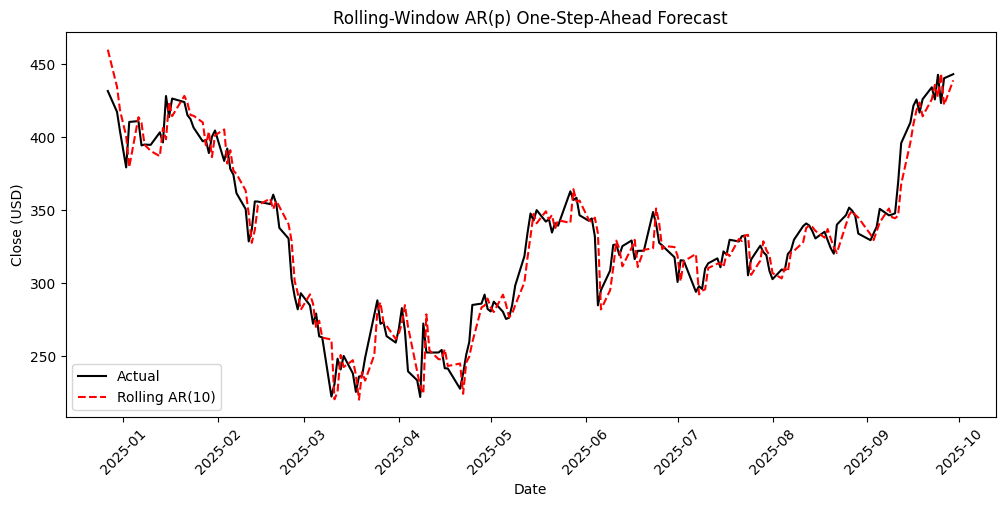

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, r2_score

y = df["Close"].to_numpy()
dates = df["Date"].to_numpy()
train_size = int(len(y) * 0.8)

p = 10       # AR 차수
W = 252      # 롤링 윈도우 길이(예: 1년 거래일)
preds = []

for t in range(train_size, len(y)):
    start_idx = max(0, t - W)
    y_win = y[start_idx:t]           # t-1까지 사용
    if y_win.shape[0] <= p:
        preds.append(np.nan)
        continue

    fit = AutoReg(y_win, lags=p, old_names=False).fit()
    yhat = fit.forecast(steps=1).item()  # ← 스칼라로 추출(Deprecation 회피)
    preds.append(yhat)

actual = y[train_size:]
preds = np.asarray(preds)

mask = ~np.isnan(preds)
mse  = mean_squared_error(actual[mask], preds[mask])  # squared 인자 X
rmse = np.sqrt(mse)                                   # 직접 sqrt
r2   = r2_score(actual[mask], preds[mask])
print(f"[Rolling AR({p})] Test RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,5))
plt.plot(dates[train_size:], actual, label="Actual", color="black")
plt.plot(dates[train_size:], preds, label=f"Rolling AR({p})", linestyle="--", color="red")
plt.title("Rolling-Window AR(p) One-Step-Ahead Forecast")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.xticks(rotation=45); plt.legend(); plt.show()


# 확장 윈도우(Expanding window)

시작 구간에서 출발해 **처음부터 t−1까지 전부**로 매 시점 재학습 → 1스텝 앞 예측.

```
[1 2 3] → 4
[1 2 3 4] → 5
[1 2 3 4 5] → 6
   ...
```

* 장점: **데이터 축적 → 안정적**
* 단점: **최근 변화 적응은 상대적으로 느림**, 계산량 증가

**의사코드**

```python
for t in range(train_end, n):
    fit = AutoReg(y[:t], lags=p).fit()
    yhat[t] = fit.forecast(1)[0]
```

[Expanding AR(10)] Test RMSE=13.2619, R²=0.9405


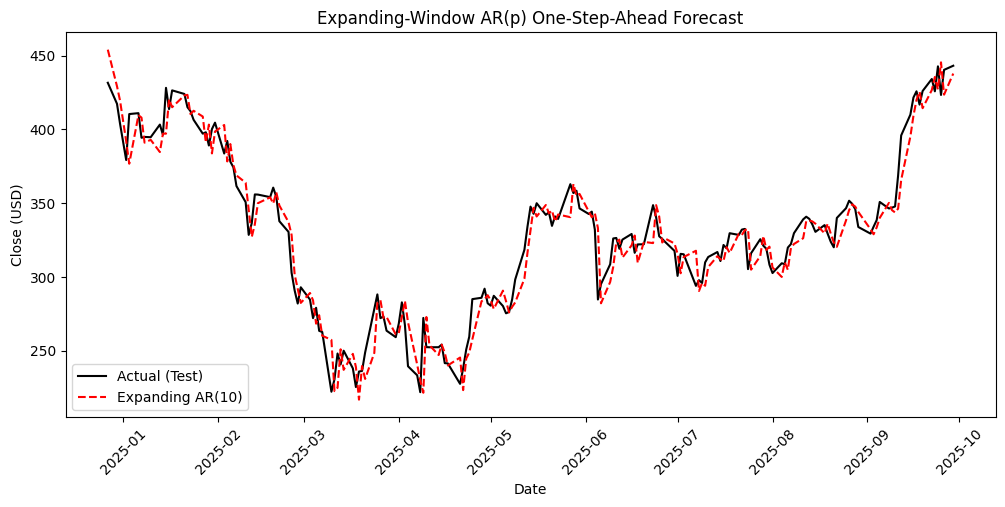

In [5]:
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

p = 10
preds_exp = []

actual = y[train_size:]                  # 테스트 실제값

for t in range(train_size, len(y)):
    y_win = y[:t]                         # 시작~t-1까지 모두 사용
    if y_win.shape[0] <= p:
        preds_exp.append(np.nan)
        continue

    fit = AutoReg(y_win, lags=p, old_names=False).fit()
    # 🔧 스칼라로 안전하게 추출 (배열/시리즈 대응)
    yhat = float(np.asarray(fit.forecast(steps=1)).ravel()[0])
    preds_exp.append(yhat)

preds_exp = np.asarray(preds_exp, dtype=float)
mask = ~np.isnan(preds_exp)

# 🔧 squared=False 대신 직접 sqrt
mse_exp  = mean_squared_error(actual[mask], preds_exp[mask])
rmse_exp = np.sqrt(mse_exp)
r2_exp   = r2_score(actual[mask], preds_exp[mask])
print(f"[Expanding AR({p})] Test RMSE={rmse_exp:.4f}, R²={r2_exp:.4f}")

# 시각화
plt.figure(figsize=(12,5))
plt.plot(df["Date"].to_numpy()[train_size:], actual, label="Actual (Test)", color="black")
plt.plot(df["Date"].to_numpy()[train_size:], preds_exp, label=f"Expanding AR({p})", linestyle="--", color="red")
plt.title("Expanding-Window AR(p) One-Step-Ahead Forecast")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.xticks(rotation=45); plt.legend(); plt.show()
